# Random Forest Hyperparameter Tunning

**Description**:\
After getting the Cross-Validation results, the aim on this notebook will be testing the models with the best results and applying the hyper parameters optimization.

**Author**: Elmo Chavez\
**Date**: October 31, 2023

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Sklearn Score metrics
#from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.metrics import accuracy_score, classification_report
# Classifier
from sklearn.ensemble import RandomForestClassifier
# Shappley method
import shap
# print the JS visualization code to the notebook
shap.initjs()
# Hyperparameters tunning method
import optuna
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# EEG Methods
path_eeg_mne = os.path.abspath(os.path.join(os.path.dirname('eeg_mne.py'), '..'))
sys.path.append(path_eeg_mne)
import eeg_mne

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

## Read the Data

Read Training Datasets

In [2]:
path = '../Training Dataset/'
file_psd_feat_all = 'PSD_Features-All_Channels.csv'
file_psd_feat_fp1 = 'PSD_Features-FP1_Channel.csv'

df_psd_features_all = pd.read_csv(path+file_psd_feat_all)
df_psd_features_fp1 = pd.read_csv(path+file_psd_feat_fp1)

print('PSD Features All Channels shape:', df_psd_features_all.shape)
print('PSD Features FP1 Channel shape:', df_psd_features_fp1.shape)

PSD Features All Channels shape: (44, 6274)
PSD Features FP1 Channel shape: (44, 334)


Read Results from Cross-Validation

In [3]:
file_results = 'Results PSD - Cross-Validation.csv'

df_results_psd_cv = pd.read_csv(path+file_results, index_col=0)
df_results_psd_cv = df_results_psd_cv.sort_values(['AUC','accuracy','f1_score'],ascending=False)
df_results_psd_cv.head(10)

feature_extraction channels     classifier        cross-validation  \
26                PSD      All        XGBoost  StratifiedShuffleSplit   
68                PSD      Fp1        XGBoost         StratifiedKFold   
64                PSD      Fp1        XGBoost                   KFold   
37                PSD      All       AdaBoost                   KFold   
59                PSD      Fp1  Random Forest         StratifiedKFold   
71                PSD      Fp1        XGBoost  StratifiedShuffleSplit   
14                PSD      All  Random Forest         StratifiedKFold   
17                PSD      All  Random Forest  StratifiedShuffleSplit   
41                PSD      All       AdaBoost         StratifiedKFold   
20                PSD      All        XGBoost                   KFold   

      feature-selection  accuracy  f1_score       AUC  
26                 chi2  0.733333  0.726450  0.750000  
68                 chi2  0.730556  0.727937  0.735000  
64  mutual_info_classif  0.708333  0.702807  0.728333  
37  mutual_info_classif  0.705556  0.701111  0.710000  
59                 chi2  0.702778  0.697013  0.710000  
71                 chi2  0.688889  0.683117  0.700000  
14                 chi2  0.683333  0.671111  0.700000  
17                 chi2  0.688889  0.680000  0.695000  
41                 chi2  0.680556  0.677143  0.695000  
20                 chi2  0.663889  0.651053  0.691667

## Quick Explore of the Data

In [4]:
eeg_mne.Dataset_Features_Summary(df_psd_features_all)
df_psd_features_all.head()

Total Features: 6274
Windows: 11 -> ['w0', 'w1', 'w10', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']
Channels: 19 -> ['C3', 'P3', 'Pz', 'C4', 'F7', 'T6', 'Fp1', 'P4', 'O1', 'F8', 'T5', 'T3', 'Cz', 'Fp2', 'F3', 'Fz', 'F4', 'O2', 'T4']
Frequency Bands: 5 -> ['beta', 'gamma', 'delta', 'theta', 'alpha']
Features: 6 -> ['std dev', 'relative power', 'total power', 'average power', 'spectral entropy', 'peak to peak']


participant_id  w0_Fp1_delta_total_power  w0_Fp2_delta_total_power  \
0        sub-001              1.482606e-10              1.399864e-10   
1        sub-002              1.079119e-10              1.114170e-10   
2        sub-004              1.405334e-10              1.227932e-10   
3        sub-005              1.656372e-10              1.305764e-10   
4        sub-006              1.592726e-10              1.492380e-10   

   w0_F3_delta_total_power  w0_F4_delta_total_power  w0_C3_delta_total_power  \
0             1.315407e-10             1.296565e-10             1.282590e-10   
1             1.113520e-10             1.128301e-10             1.113290e-10   
2             1.387294e-10             1.335640e-10             1.315632e-10   
3             1.400050e-10             1.418274e-10             1.371958e-10   
4             1.578813e-10             1.494216e-10             1.517660e-10   

   w0_C4_delta_total_power  w0_P3_delta_total_power  w0_P4_delta_total_power  \
0             1.303774e-10             1.333272e-10             1.370710e-10   
1             1.130439e-10             1.129429e-10             1.143529e-10   
2             1.274436e-10             1.349376e-10             1.327209e-10   
3             1.362168e-10             1.447223e-10             1.434388e-10   
4             1.446006e-10             1.480658e-10             1.489056e-10   

   w0_O1_delta_total_power  ...  w10_T3_gamma_peak_to_peak  \
0             1.435011e-10  ...               3.386688e-13   
1             1.139642e-10  ...               2.484285e-13   
2             1.358135e-10  ...               4.622522e-13   
3             1.424622e-10  ...               2.383642e-12   
4             1.517877e-10  ...               9.004288e-13   

   w10_T4_gamma_peak_to_peak  w10_T5_gamma_peak_to_peak  \
0               2.955004e-13               5.828301e-13   
1               2.515664e-13               2.061092e-13   
2               5.365377e-13               3.226660e-13   
3               4.735548e-13               4.784333e-13   
4               3.977423e-13               4.030327e-13   

   w10_T6_gamma_peak_to_peak  w10_Fz_gamma_peak_to_peak  \
0               3.091508e-13               2.907760e-13   
1               2.073052e-13               1.989391e-13   
2               3.864883e-13               2.263159e-13   
3               4.677075e-13               3.885211e-13   
4               4.308146e-13               3.449713e-13   

   w10_Cz_gamma_peak_to_peak  w10_Pz_gamma_peak_to_peak  Gender  Age  Group  
0               2.915964e-13               2.048106e-13       0   57      0  
1               1.647601e-13               1.809839e-13       0   78      0  
2               1.842558e-13               2.225526e-13       0   67      0  
3               2.389231e-13               2.789744e-13       1   70      0  
4               2.547785e-13               2.279764e-13       0   61      0  

[5 rows x 6274 columns]

In [5]:
eeg_mne.Dataset_Features_Summary(df_psd_features_fp1)
df_psd_features_fp1.head()

Total Features: 334
Windows: 11 -> ['w0', 'w1', 'w10', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']
Channels: 1 -> ['Fp1']
Frequency Bands: 5 -> ['beta', 'gamma', 'delta', 'theta', 'alpha']
Features: 6 -> ['std dev', 'relative power', 'total power', 'average power', 'spectral entropy', 'peak to peak']


participant_id  w0_Fp1_delta_total_power  w1_Fp1_delta_total_power  \
0        sub-001              1.482606e-10              1.539664e-10   
1        sub-002              1.079119e-10              1.032955e-10   
2        sub-004              1.405334e-10              1.819675e-10   
3        sub-005              1.656372e-10              1.230197e-10   
4        sub-006              1.592726e-10              1.497835e-10   

   w2_Fp1_delta_total_power  w3_Fp1_delta_total_power  \
0              1.640913e-10              1.277807e-10   
1              1.220342e-10              1.187597e-10   
2              1.542677e-10              1.718428e-10   
3              1.331212e-10              1.666786e-10   
4              1.307667e-10              1.378685e-10   

   w4_Fp1_delta_total_power  w5_Fp1_delta_total_power  \
0              1.546334e-10              1.602554e-10   
1              1.227705e-10              1.210614e-10   
2              1.167535e-10              1.211645e-10   
3              1.776709e-10              1.571387e-10   
4              1.364859e-10              1.274019e-10   

   w6_Fp1_delta_total_power  w7_Fp1_delta_total_power  \
0              1.522455e-10              1.391906e-10   
1              1.277992e-10              1.234906e-10   
2              1.382233e-10              1.551854e-10   
3              1.633155e-10              1.683460e-10   
4              1.437636e-10              1.490190e-10   

   w8_Fp1_delta_total_power  ...  w4_Fp1_gamma_peak_to_peak  \
0              1.629814e-10  ...               7.380106e-13   
1              1.256641e-10  ...               7.699532e-13   
2              1.771741e-10  ...               8.399157e-13   
3              1.507685e-10  ...               1.491440e-12   
4              1.466645e-10  ...               3.440082e-13   

   w5_Fp1_gamma_peak_to_peak  w6_Fp1_gamma_peak_to_peak  \
0               5.186201e-13               5.164246e-13   
1               3.676913e-13               2.817223e-13   
2               8.695519e-13               7.697982e-13   
3               1.000392e-12               7.040914e-13   
4               3.092531e-13               3.348430e-13   

   w7_Fp1_gamma_peak_to_peak  w8_Fp1_gamma_peak_to_peak  \
0               4.919865e-13               4.522907e-13   
1               2.394770e-13               3.544304e-13   
2               8.206731e-13               6.854909e-13   
3               7.395305e-13               1.422540e-12   
4               3.375979e-13               3.341492e-13   

   w9_Fp1_gamma_peak_to_peak  w10_Fp1_gamma_peak_to_peak  Gender  Age  Group  
0               4.652932e-13                5.643991e-13       0   57      0  
1               2.473381e-13                2.063013e-13       0   78      0  
2               4.246755e-13                4.607840e-13       0   67      0  
3               2.014033e-12                1.652614e-12       1   70      0  
4               4.838252e-13                4.263739e-13       0   61      0  

[5 rows x 334 columns]

**Note**\
For all the score metrics the best model has been the XGBoost. Then the AdaBoost and Random Forest had a great performance.

List to save scores

In [6]:
list_scores = []

# Random Forest Modeling

## All Channels

In [7]:
cols_to_drop = ['participant_id','Group']

In [8]:
X = df_psd_features_all.drop(columns=cols_to_drop).values
feature_names = df_psd_features_all.drop(columns=cols_to_drop).columns.to_list()
y = df_psd_features_all['Group'].values

### Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Classifier - Default Parameters

In [10]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Train Test Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 36.36 %
F1 Score: 34.19 %
AUC: 38.33 %


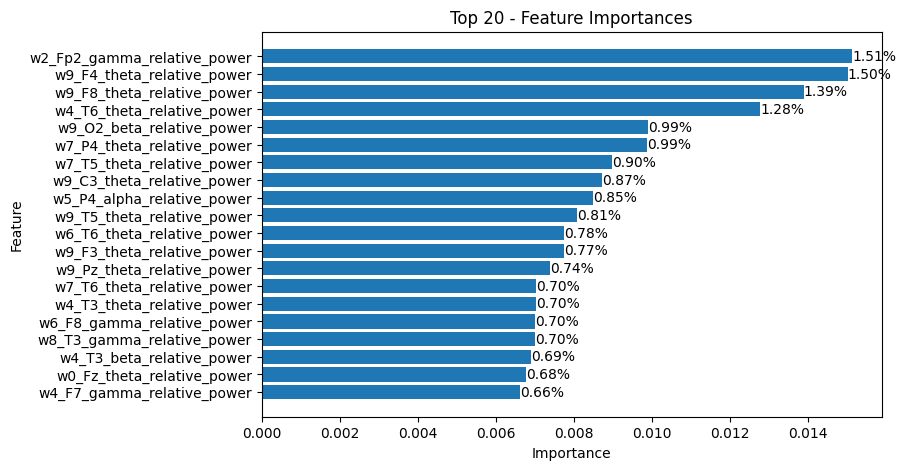

In [11]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_all.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

### StratifiedShuffleSplit (New Approach)

In [12]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print('Train:', X_train.shape[0])
print('Train:', X_test.shape[0])

Train: 33
Train: 11


#### Classifier - Default Parameters

In [13]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 63.64 %
F1 Score: 60.71 %
AUC: 61.67 %


In [14]:
best_clf = clf

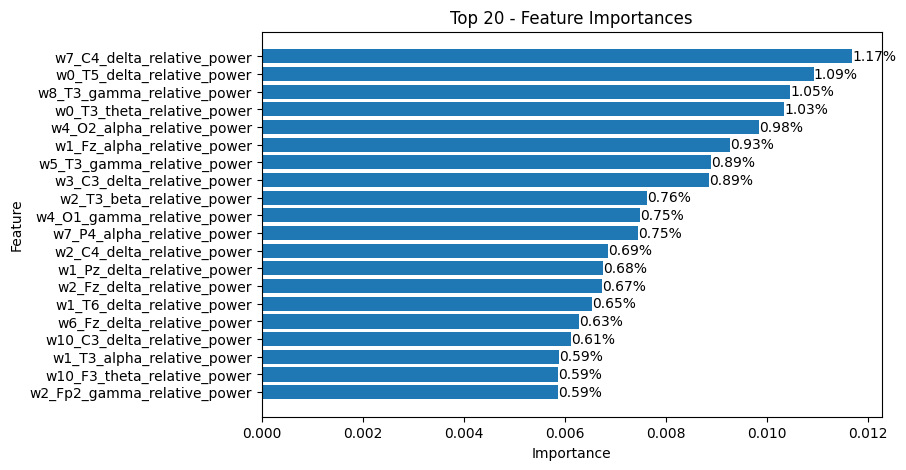

In [15]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_all.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

In [16]:
print('Number of Features used:', df_feat_importance[df_feat_importance['Importance']>0].shape[0])
df_feat_importance[df_feat_importance['Importance']>0.005]

Number of Features used: 387


Feature  Importance
347    w7_C4_delta_relative_power    0.011698
223    w0_T5_delta_relative_power    0.010935
5389   w8_T3_gamma_relative_power    0.010470
1475   w0_T3_theta_relative_power    0.010349
2802   w4_O2_alpha_relative_power    0.009849
2752   w1_Fz_alpha_relative_power    0.009269
5332   w5_T3_gamma_relative_power    0.008900
270    w3_C3_delta_relative_power    0.008857
4021    w2_T3_beta_relative_power    0.007634
5309   w4_O1_gamma_relative_power    0.007501
2857   w7_P4_alpha_relative_power    0.007459
252    w2_C4_delta_relative_power    0.006857
246    w1_Pz_delta_relative_power    0.006764
263    w2_Fz_delta_relative_power    0.006734
243    w1_T6_delta_relative_power    0.006540
339    w6_Fz_delta_relative_power    0.006285
403   w10_C3_delta_relative_power    0.006124
2748   w1_T3_alpha_relative_power    0.005881
1655  w10_F3_theta_relative_power    0.005875
5264  w2_Fp2_gamma_relative_power    0.005872
1662  w10_O2_theta_relative_power    0.005808
1513   w2_T3_theta_relative_power    0.005801
235    w1_P4_delta_relative_power    0.005736
4083    w5_Cz_beta_relative_power    0.005733
5429  w10_T5_gamma_relative_power    0.005701
1528   w3_O1_theta_relative_power    0.005680
2768   w2_T4_alpha_relative_power    0.005558
2881   w8_T3_alpha_relative_power    0.005512
4019    w2_F7_beta_relative_power    0.005477
4070    w5_C3_beta_relative_power    0.005448
5396  w9_Fp1_gamma_relative_power    0.005273
1586   w6_O2_theta_relative_power    0.005260
5233   w0_O1_gamma_relative_power    0.005249
2895   w9_P4_alpha_relative_power    0.005161
1611   w7_T6_theta_relative_power    0.005156
1511   w2_F7_theta_relative_power    0.005144
1492   w1_F7_theta_relative_power    0.005142

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.67      0.40      0.50         5

    accuracy                           0.64        11
   macro avg       0.65      0.62      0.61        11
weighted avg       0.64      0.64      0.62        11



#### SHAP

In [18]:
explainer = shap.KernelExplainer(best_clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/11 [00:00<?, ?it/s]

In [19]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, feature_names)

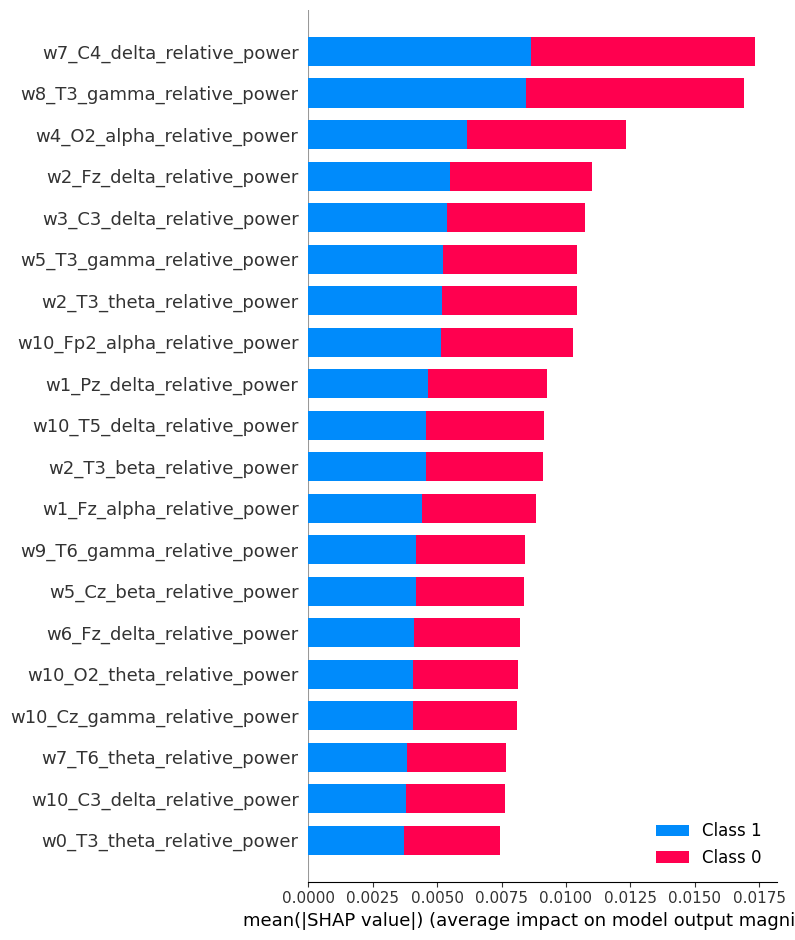

In [20]:
shap.summary_plot(shap_values, df_psd_features_all.drop(columns=cols_to_drop))

#### Hyperparameters Tunning

In [21]:
def objective(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)
    max_features = trial.suggest_categorical(name="max_features", choices=[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-12-18 00:26:34,672] A new study created in memory with name: no-name-55529ab3-9679-4871-8f80-afb245dc7cd1
[I 2023-12-18 00:26:35,534] Trial 0 finished with value: 0.5095238095238096 and parameters: {'n_estimators': 400, 'max_features': 30, 'max_depth': 70, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5095238095238096.
[I 2023-12-18 00:26:35,762] Trial 1 finished with value: 0.45714285714285713 and parameters: {'n_estimators': 100, 'max_features': 50, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5095238095238096.
[I 2023-12-18 00:26:36,365] Trial 2 finished with value: 0.5428571428571429 and parameters: {'n_estimators': 300, 'max_features': 20, 'max_depth': 110, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.5428571428571429.
[I 2023-12-18 00:26:36,574] Trial 3 finished with value: 0.5142857142857142 and parameters: {'n_estimators': 100, 'max_features': 50, 'max_dept

Number of finished trials: 10
Best trial:
  Value: 0.5714285714285714
  Params: 
    n_estimators: 400
    max_features: 1
    max_depth: 90
    min_samples_split: 2
    min_samples_leaf: 3


In [23]:
clf = RandomForestClassifier(**study.best_params, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Stratified Shuffle Split - Parameters Optimized'
list_scores.append(scores)

-- Scores: --
Accuracy: 63.64 %
F1 Score: 63.33 %
AUC: 63.33 %


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.60      0.60      0.60         5

    accuracy                           0.64        11
   macro avg       0.63      0.63      0.63        11
weighted avg       0.64      0.64      0.64        11



#### Classifier - Using Feature Selection

In [25]:
selector = SelectKBest(score_func=chi2, k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

clf = RandomForestClassifier()
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'All'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters - Feature Selection'
list_scores.append(scores)

-- Scores: --
Accuracy: 63.64 %
F1 Score: 63.33 %
AUC: 65.0 %


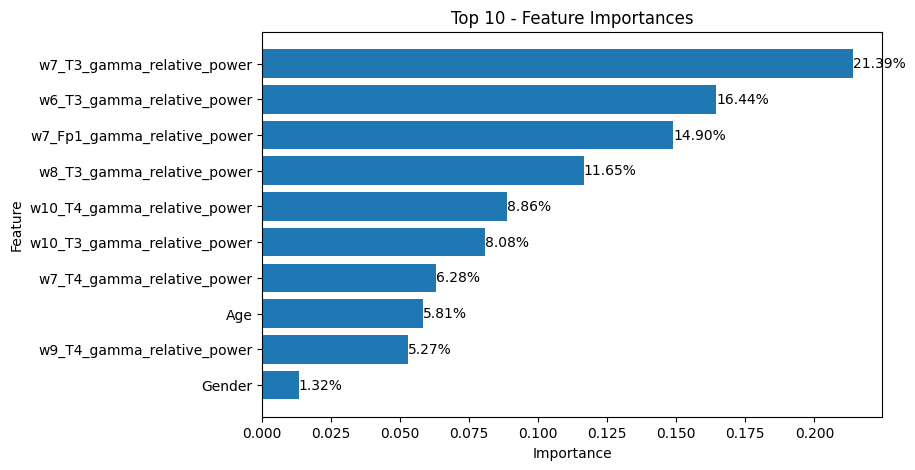

In [26]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(selector.get_feature_names_out(feature_names).tolist(),
                               clf.feature_importances_.tolist(),
                               top_n=10)

## FP1 Channel

In [27]:
X = df_psd_features_fp1.drop(columns=cols_to_drop).values
feature_names = df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list()
y = df_psd_features_fp1['Group'].values

### Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Classifier - Default Parameters

In [29]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Train Test Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 64.29 %
F1 Score: 64.1 %
AUC: 64.58 %


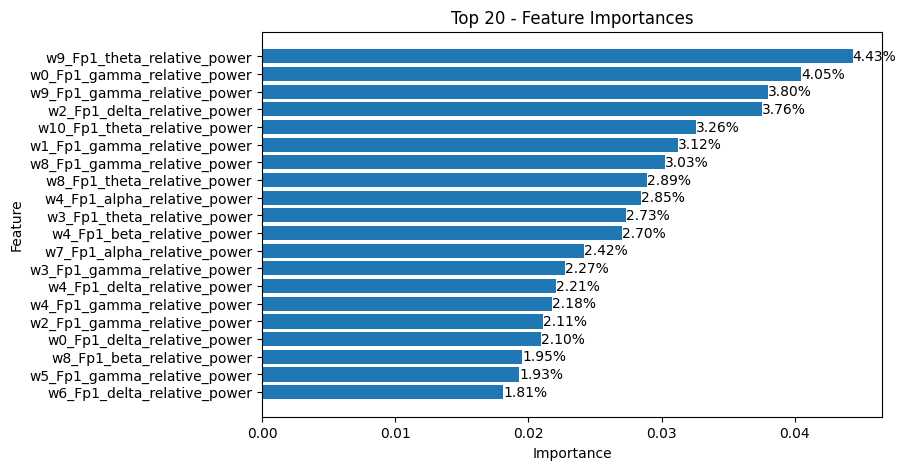

In [30]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

### StratifiedShuffleSplit (New Approach)

In [31]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.28, random_state=42)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Classifier - Default Parameters

In [32]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters'
list_scores.append(scores)

-- Scores: --
Accuracy: 76.92 %
F1 Score: 76.36 %
AUC: 76.19 %


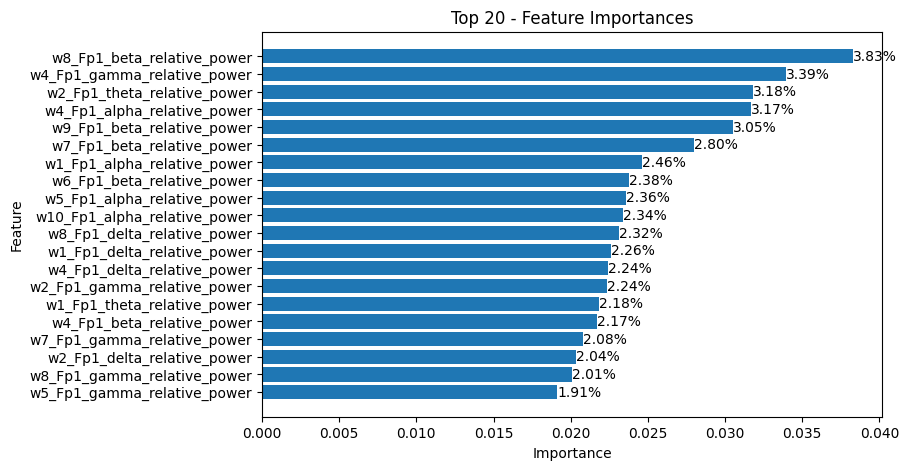

In [33]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

In [34]:
best_clf = clf

#### SHAP

In [35]:
explainer = shap.KernelExplainer(best_clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/13 [00:00<?, ?it/s]

In [36]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, feature_names)

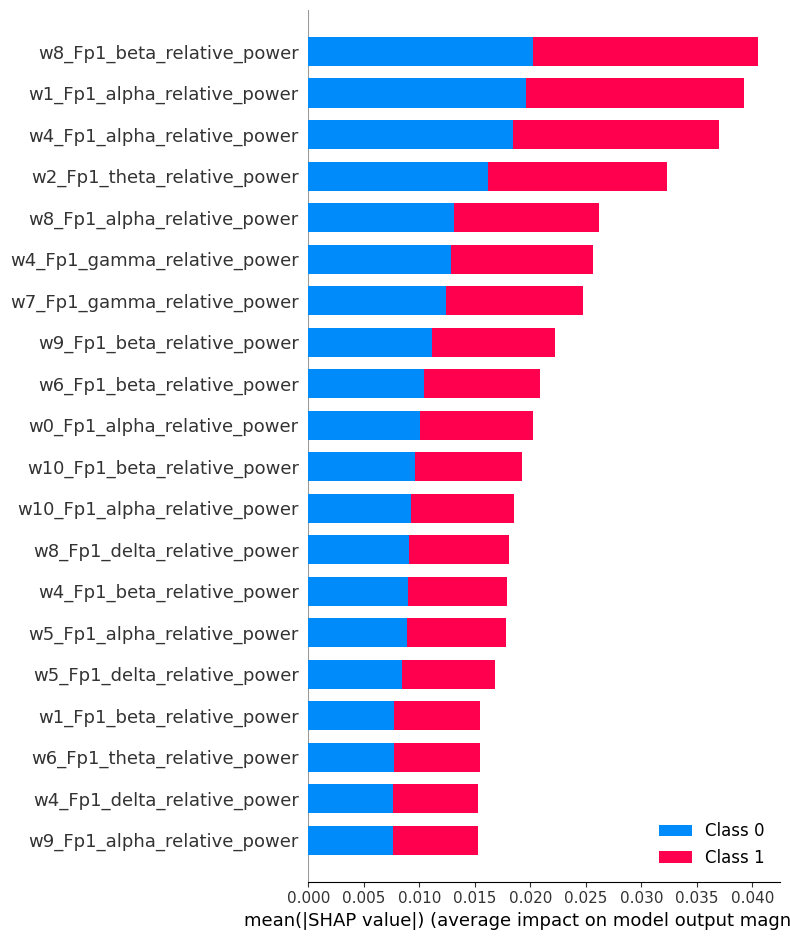

In [37]:
shap.summary_plot(shap_values, df_psd_features_fp1.drop(columns=cols_to_drop))

#### Hyperparameters Tunning

In [38]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-12-18 00:27:03,227] A new study created in memory with name: no-name-99959a6c-d0f0-4d82-aad5-9b6d73bee203
[I 2023-12-18 00:27:03,824] Trial 0 finished with value: 0.4809523809523809 and parameters: {'n_estimators': 300, 'max_features': 10, 'max_depth': 70, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4809523809523809.
[I 2023-12-18 00:27:04,477] Trial 1 finished with value: 0.5095238095238095 and parameters: {'n_estimators': 300, 'max_features': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.5095238095238095.
[I 2023-12-18 00:27:04,921] Trial 2 finished with value: 0.5142857142857142 and parameters: {'n_estimators': 200, 'max_features': 90, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.5142857142857142.
[I 2023-12-18 00:27:05,693] Trial 3 finished with value: 0.4809523809523809 and parameters: {'n_estimators': 400, 'max_features': 10, 'max_dept

Number of finished trials: 10
Best trial:
  Value: 0.5476190476190477
  Params: 
    n_estimators: 100
    max_features: 60
    max_depth: 90
    min_samples_split: 4
    min_samples_leaf: 1


In [39]:
clf = RandomForestClassifier(**trial.params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Stratified Shuffle Split - Parameters Optimized'
list_scores.append(scores)

-- Scores: --
Accuracy: 61.54 %
F1 Score: 61.54 %
AUC: 61.9 %


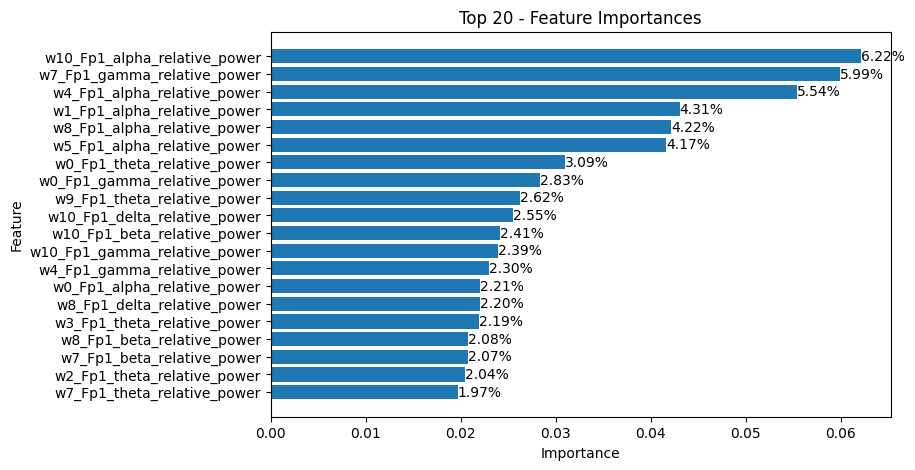

In [40]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(df_psd_features_fp1.drop(columns=cols_to_drop).columns.to_list(),
                               clf.feature_importances_.tolist(),
                               top_n=20)

#### Classifier - Using Feature Selection

In [41]:
selector = SelectKBest(score_func=chi2, k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

clf = RandomForestClassifier()
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
scores = eeg_mne.get_Scores(y_test, y_pred, True)
scores['Channels'] = 'FP1'
scores['Approach'] = 'Stratified Shuffle Split - Default Parameters - Feature Selection'
list_scores.append(scores)

-- Scores: --
Accuracy: 61.54 %
F1 Score: 61.54 %
AUC: 61.9 %


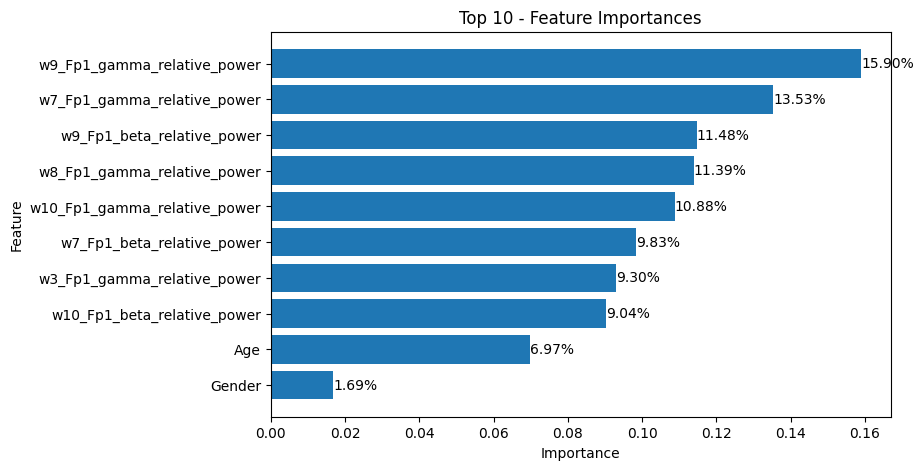

In [42]:
# Get feature importance scores
df_feat_importance = eeg_mne.get_Feature_Importance(selector.get_feature_names_out(feature_names).tolist(),
                               clf.feature_importances_.tolist(),
                               top_n=10)

## Results

In [43]:
df_results = pd.DataFrame(list_scores)
df_results = df_results[['Approach', 'Channels', 'Accuracy', 'F1 Score', 'AUC']]
df_results

Approach Channels  Accuracy  \
0              Train Test Split - Default Parameters      All  0.363636   
1      Stratified Shuffle Split - Default Parameters      All  0.636364   
2    Stratified Shuffle Split - Parameters Optimized      All  0.636364   
3  Stratified Shuffle Split - Default Parameters ...      All  0.636364   
4              Train Test Split - Default Parameters      FP1  0.642857   
5      Stratified Shuffle Split - Default Parameters      FP1  0.769231   
6    Stratified Shuffle Split - Parameters Optimized      FP1  0.615385   
7  Stratified Shuffle Split - Default Parameters ...      FP1  0.615385   

   F1 Score       AUC  
0  0.341880  0.383333  
1  0.607143  0.616667  
2  0.633333  0.633333  
3  0.633333  0.650000  
4  0.641026  0.645833  
5  0.763636  0.761905  
6  0.615385  0.619048  
7  0.615385  0.619048